---

# Notebook : Création de pipeline et évaluation par validation croisée des modèles validés

**Objectifs :**
1. Créer une pipeline scikit-learn pour intégrer le prétraitement et l'entraînement des modèles validés.
2. Utiliser la validation croisée pour obtenir des scores moyens et des écarts-types (MSE, R²) pour chaque modèle sur un échantillon de 10% des données.
3. Comparer visuellement les performances des modèles et identifier le modèle le plus stable.

---

## Étape 1 : Importer les bibliothèques nécessaires et charger les modèles sauvegardés

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import joblib
import numpy as np
import matplotlib.pyplot as plt

---

## Étape 2 : Charger les données et préparer un échantillon de 10%

In [2]:
# Charger les données complètes
file_path = 'note-books/phase_2_training/04_correlation_analysis/data_final_features.csv'
df = pd.read_csv(file_path)

# Encoder `nutriscore_grade` en valeurs numériques
df['nutriscore_grade_encoded'] = df['nutriscore_grade'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4})

# Préparer les variables explicatives et la cible
X = df[['fat_100g', 'saturated-fat_100g', 'energy_100g', 'energy-kcal_100g', 'sugars_100g']]
y = df['nutriscore_grade_encoded']

# Prendre un échantillon de 10% des données pour l’entraînement
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9, random_state=42)

---

## Étape 3 : Charger les modèles sauvegardés et configurer les pipelines

Les pipelines incluent une étape de **standardisation** suivie de l’entraînement du modèle.

In [3]:
# Charger les modèles sauvegardés
model_paths = {
    'Gradient Boosting': 'note-books/phase_2_training/06_model_selection_comparison/Gradient_Boosting_optimized.joblib',
    'Random Forest': 'note-books/phase_2_training/06_model_selection_comparison/Random_Forest_optimized.joblib'
}

# Créer des pipelines pour chaque modèle
pipelines = {}
for model_name, model_path in model_paths.items():
    model = joblib.load(model_path)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

---

## Étape 4 : Évaluation des modèles avec validation croisée

Nous utiliserons une **validation croisée à 5 plis** pour chaque modèle et enregistrerons les scores moyens et écarts-types de MSE et R².

In [4]:
# Configurer les scores pour la validation croisée
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

# Initialiser les résultats
results = {
    'Model': [],
    'MSE Mean': [],
    'MSE Std Dev': [],
    'R² Mean': [],
    'R² Std Dev': []
}

# Évaluer chaque modèle avec validation croisée
for model_name, pipeline in pipelines.items():
    print(f"Évaluation de {model_name} en cours...")

    # Validation croisée
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kfold, scoring=scoring['MSE'])
    r2_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kfold, scoring=scoring['R²'])

    # Stocker les résultats
    results['Model'].append(model_name)
    results['MSE Mean'].append(-np.mean(mse_scores))
    results['MSE Std Dev'].append(np.std(mse_scores))
    results['R² Mean'].append(np.mean(r2_scores))
    results['R² Std Dev'].append(np.std(r2_scores))

    print(f"{model_name} terminé. MSE moyen : {-np.mean(mse_scores)}, Écart-type MSE : {np.std(mse_scores)}, "
          f"R² moyen : {np.mean(r2_scores)}, Écart-type R² : {np.std(r2_scores)}")

Évaluation de Gradient Boosting en cours...
Gradient Boosting terminé. MSE moyen : 0.6943429339522699, Écart-type MSE : 0.01876613887835317, R² moyen : 0.6132667104666145, Écart-type R² : 0.00954836126253223
Évaluation de Random Forest en cours...
Random Forest terminé. MSE moyen : 0.6628380203153653, Écart-type MSE : 0.026334295803837334, R² moyen : 0.631733548056315, Écart-type R² : 0.01396120240681032


---

## Étape 5 : Afficher les résultats sous forme de graphiques

Nous afficherons les résultats sous forme de **barres d'erreur** pour visualiser les performances des modèles et faciliter la comparaison.

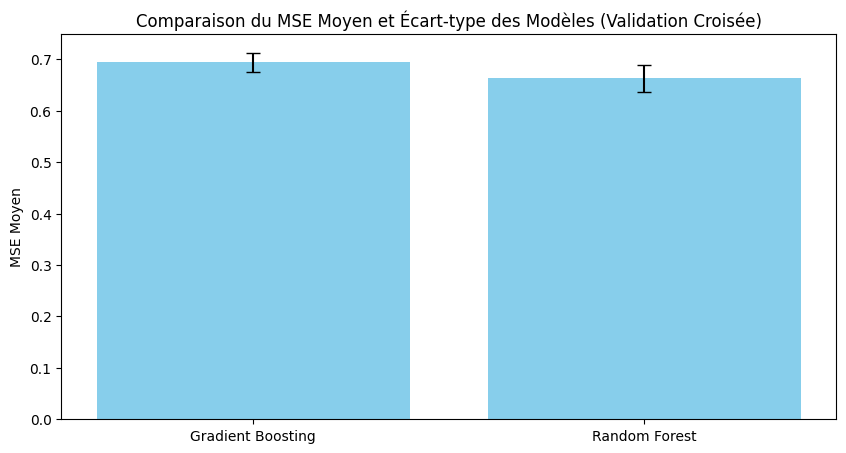

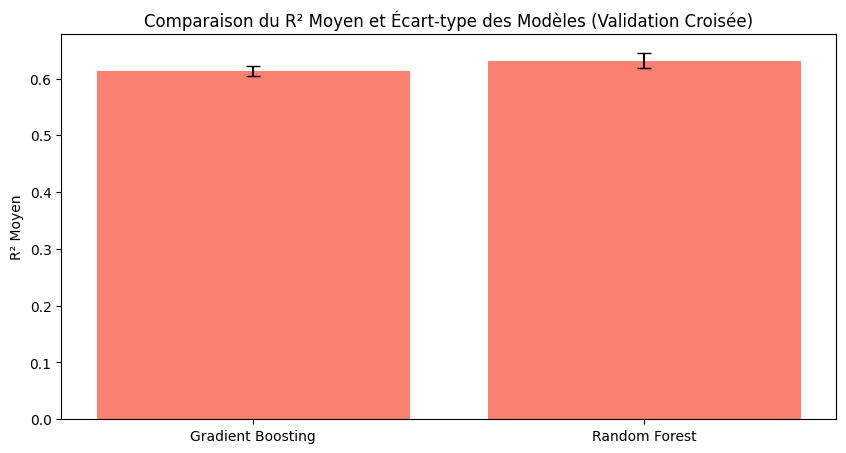

In [5]:
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Graphique pour le MSE moyen avec écart-type
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['MSE Mean'], yerr=results_df['MSE Std Dev'], capsize=5, color='skyblue')
plt.ylabel('MSE Moyen')
plt.title("Comparaison du MSE Moyen et Écart-type des Modèles (Validation Croisée)")
plt.show()

# Graphique pour le R² moyen avec écart-type
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['R² Mean'], yerr=results_df['R² Std Dev'], capsize=5, color='salmon')
plt.ylabel('R² Moyen')
plt.title("Comparaison du R² Moyen et Écart-type des Modèles (Validation Croisée)")
plt.show()

---

### Explication des étapes

1. **Pipeline pour chaque modèle** : Nous avons créé une pipeline incluant une étape de standardisation et le modèle final.
2. **Validation croisée à 5 plis** : La validation croisée permet de mesurer la robustesse de chaque modèle, avec des moyennes et écarts-types pour MSE et R².
3. **Comparaison visuelle** : Les graphiques de barres avec erreurs standards offrent une vue d'ensemble des performances des modèles, permettant de voir le modèle le plus stable et précis.

---

### Résumé

Dans ce notebook, nous avons :
1. Créé une pipeline pour le prétraitement et l’entraînement de chaque modèle validé.
2. Évalué la robustesse de `Gradient Boosting` et `Random Forest` avec une validation croisée sur un échantillon de 10% des données.
3. Comparé les performances en affichant le MSE moyen et le R² moyen avec leurs écarts-types pour chaque modèle.

Ces graphiques facilitent la comparaison et aident à identifier le modèle le plus stable, en fonction des scores de validation croisée obtenus.